# Loading the libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

import os
import sys
import random
import warnings
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)

import numpy as np
import pandas as pd
from skimage.color import rgb2gray


from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import cv2
import imutils


c:\users\abhijit\anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_PATH = 'D:/vip_test/'
TEST_PATH = 'D:/vip_test/'

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
print(train_ids)

['LUNG1-043', 'LUNG1-044']


In [6]:
path_train = 'E:/vip_cup/path_train/'
path_mask = 'E:/vip_cup/path_mask/'

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    
    next_ids = next(os.walk(path))[1]
    
    dicom_path_train =  path+ '/' + next_ids[0]+'/'+'DICOM'+'/'
    dicom_path_mask = path +'/'+next_ids[1] + '/'+'secondary'+'/'+'000000.dcm'
    
    #print(next_ids[1])
    data_mask_load(dicom_path_mask,dicom_path_train,path_train,path_mask)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.15s/it]


In [20]:
print(RefDs)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0012) Instance Creation Date              DA: '20090530'
(0008, 0013) Instance Creation Time              TM: '130503'
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.32722.99.99.29592584416278349521623001105151733743
(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.32722.178965064163024236947827461027677407381
(0008, 0020) Study Date                          DA: '20140101'
(0008, 0030) Study Time                          TM: ''
(0008, 0050) Accession Number                    SH: '2615788742648199'
(0008, 0060) Modality                            CS: 'RTSTRUCT'
(0008, 0070) Manufacturer                        LO: 'CMS, Inc.'
(0008, 0090) Referring Physician's Name          PN: ' '
(0008, 1070) Operators' Name                     PN: ' '
(0008, 1090) Manufacturer's Model Name           LO: 'XiO'
(0010, 00

   ---------


# Reading the dicom file & save the train image & masks to a folder

In [5]:
def data_mask_load(path_contour, path_images,path_train,path_mask):
    # Grab important data only from dcm
    dcm_obj = dcm.read_file(path_contour)
    contours = dcm_obj[0x3006, 0x0039][0][0x3006, 0x0040]
    contour_data = {}
    for contour in contours:
        slice_id = contour[0x3006, 0x0016][0][0x0008, 0x1155].value
        path = [] 
        contour_list = contour[0x3006, 0x0050].value
        contour_list = [float(x) for x in contour_list]
        i = 0
        while 3 * i < len(contour_list):
            path.append([contour_list[3 * i], contour_list[3 * i + 1]])
            i += 3
        contour_data[slice_id] = path
        
        #print(contour_data)
        
    try:
        os.mkdir(path )
    except:
        pass
    
    for img in os.listdir(path_images):
        dcm_obj = dcm.read_file(path_images + img)
        slice_id = dcm_obj[0x0008, 0x0018].value
        
        #print(slice_id)
        image_data = dcm_obj.pixel_array
        mask_data = np.zeros(image_data.shape)
        #print(mask_data)
        
        if slice_id in contour_data:
            ref = [float(x) for x in dcm_obj[0x0020, 0x0032].value[:2]]
            spacing = [float(x) for x in dcm_obj[0x0028, 0x0030].value]
            
            row_col = list()
            
            for pos in contour_data[slice_id]:
                col = int((pos[0] - ref[0]) / spacing[0])
                row = int((pos[1] - ref[1]) / spacing[1])
                
                cor = np.array([row,col])
                row_col.append(cor)
                
                #print(row_col)
            bound = np.array(row_col)
            #print(bound)
            
            cv2.fillPoly(mask_data, pts =[bound], color=(256,256,256))
            
        cv2.imwrite(path_train  + slice_id.replace('.', '_') + '.png', image_data)
        cv2.imwrite(path_mask  + slice_id.replace('.', '_') + '.png', mask_data)

# Doing some preprocessing like Histogram to image data 

In [73]:
#loading the data & preprocess
import skimage as sk
from skimage import filters
import pandas as pd

train_path = 'E:/vip_cup/path_train/'
mask_path  = 'E:/vip_cup/path_mask/'


partition = pd.DataFrame()

train = list()

for i in os.listdir(train_path):
    imag = train_path+i
    #img = cv2.imread(imag,0)
    #equ = cv2.equalizeHist(img)
    train.append(imag)
    #partition['train'][i] = imag
    #partition['label'][i] = imag
    
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #cl1 = clahe.apply(img)
    
    #imshow(cl1)
    #plt.show()
    
    #image = normalize(img)
    #equ = cv2.equalizeHist(img)
    
    
    
    #imshow(histo)
    #plt.show()
    #sk.io.imshow(histo)
    #sk.io.show()
train_list = np.array(train)  

mask = list()

for i in os.listdir(mask_path):
    imag = mask_path+i
    #img = cv2.imread(imag,0)
    #equ = cv2.equalizeHist(img)
    mask.append(imag)
    #partition['train'][i] = imag
    #partition['label'][i] = imag
    
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #cl1 = clahe.apply(img)
    
    #imshow(cl1)
    #plt.show()
    
    #image = normalize(img)
    #equ = cv2.equalizeHist(img)
    
    
    
    #imshow(histo)
    #plt.show()
    #sk.io.imshow(histo)
    #sk.io.show()
mask_list = np.array(mask)  
    

# Normalising the data 

In [38]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

# Data generator for image & mask

In [133]:
#Data generator
import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import cv2
import imutils


class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs,mask_id, batch_size=32, dim=(512,512), n_channels=1,
              shuffle=True):
    #'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.mask_id = mask_id
        self.n_channels = n_channels
    #self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
  #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

          

    def __len__(self):
  #'Denotes the number of batches per epoch'
      return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
  #'Generate one batch of data'
  # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

  # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        list_IDs_mask = [self.mask_id[k] for k in indexes]

  # Generate data
        X,y = self.__data_generation(list_IDs_temp,list_IDs_mask)
        #y = self.__data_generation(list_IDs_mask)
        return X, y


    def __data_generation(self, list_IDs_temp,list_IDs_mask):
  #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
  # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim,self.n_channels))
        #print(list_IDs_mask)
  # Generate data
        for i, ID in enumerate(list_IDs_temp):
      # Store sample
            img = cv2.imread(ID,0)
            img = img.reshape(512,512,1)
            X[i,] =  img 
            
        for i,ID in enumerate(list_IDs_mask):
            img = cv2.imread(ID,0)
            img = img.reshape(512,512,1)
            y[i,] = img
            
      # Store class
        #y[i] = self.labels[ID]

        return X, y  

In [56]:
#Data generator from keras

from keras.preprocessing.image import ImageDataGenerator 

data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=0,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(vip_cup, augment=True, seed=seed)
#mask_datagen.fit(vip, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    'E:/vip_cup/',
    class_mode = None,target_size = (512,512),color_mode = 'grayscale',
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    'E:/vip/',
    class_mode = None,target_size = (512,512),color_mode = 'grayscale',
    seed=seed)


train_generator = zip(image_generator, mask_generator)


Found 197 images belonging to 1 classes.
Found 197 images belonging to 1 classes.


# The trainer architecture

In [57]:
IMG_CHANNELS = 3
IMG_HEIGHT = 512
IMG_WIDTH = 512

inputs = Input((IMG_HEIGHT, IMG_WIDTH,1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 512, 512, 1)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_249 (Conv2D)             (None, 512, 512, 8)  80          lambda_15[0][0]                  
__________________________________________________________________________________________________
conv2d_250 (Conv2D)             (None, 512, 512, 8)  584         conv2d_249[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [107]:
model.fit_generator(
    train_generator,
    steps_per_epoch=32,
    epochs=2)

Epoch 1/2
32/32 [==============================] - ETA: 41s - loss: -9.2438 - acc: 0.926 - ETA: 21s - loss: -7.5176 - acc: 0.915 - ETA: 22s - loss: -9.1527 - acc: 0.927 - ETA: 23s - loss: -7.4038 - acc: 0.933 - ETA: 22s - loss: -7.9887 - acc: 0.930 - ETA: 22s - loss: -7.7935 - acc: 0.928 - ETA: 21s - loss: -8.3908 - acc: 0.925 - ETA: 20s - loss: -8.1164 - acc: 0.923 - ETA: 17s - loss: -7.1192 - acc: 0.925 - ETA: 17s - loss: -7.0269 - acc: 0.921 - ETA: 16s - loss: -6.7904 - acc: 0.920 - ETA: 16s - loss: -7.2022 - acc: 0.920 - ETA: 15s - loss: -7.1326 - acc: 0.921 - ETA: 14s - loss: -7.7012 - acc: 0.923 - ETA: 14s - loss: -7.8696 - acc: 0.924 - ETA: 12s - loss: -7.3383 - acc: 0.926 - ETA: 11s - loss: -7.2245 - acc: 0.928 - ETA: 11s - loss: -7.3140 - acc: 0.929 - ETA: 10s - loss: -7.3133 - acc: 0.930 - ETA: 9s - loss: -7.6710 - acc: 0.930 - ETA: 8s - loss: -7.5697 - acc: 0.92 - ETA: 8s - loss: -7.6102 - acc: 0.92 - ETA: 7s - loss: -7.6341 - acc: 0.92 - ETA: 6s - loss: -7.6724 - acc: 0.92 

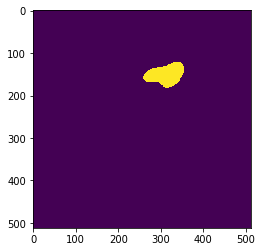

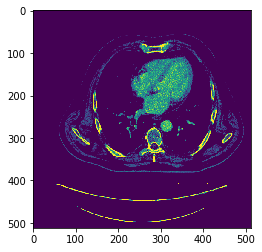

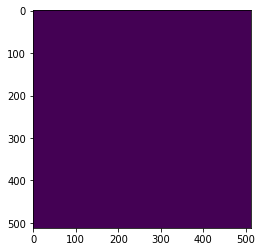

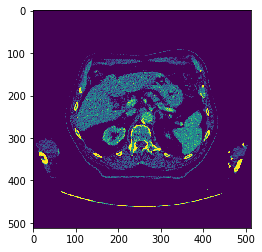

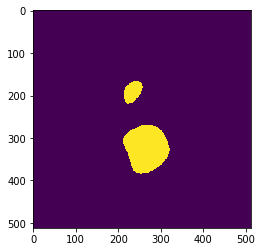

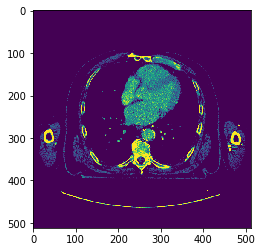

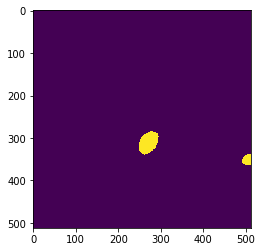

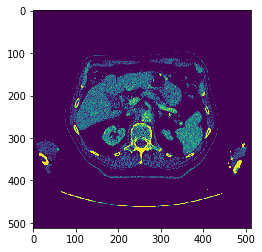

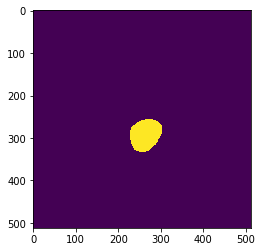

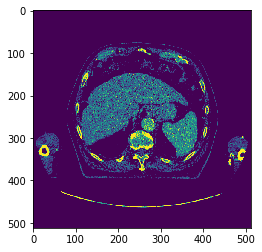

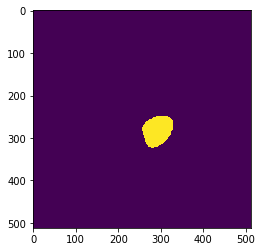

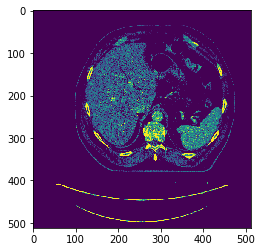

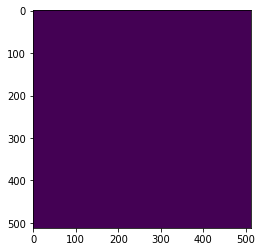

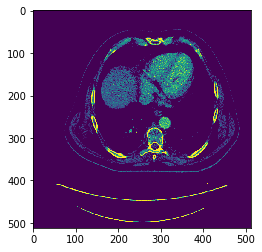

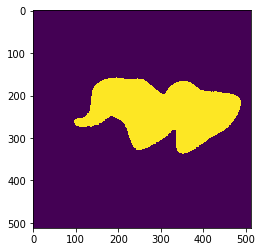

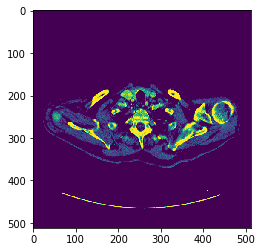

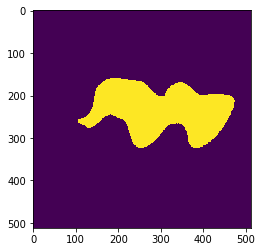

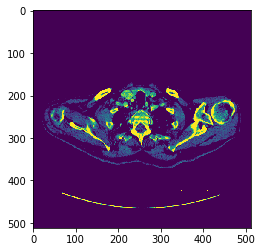

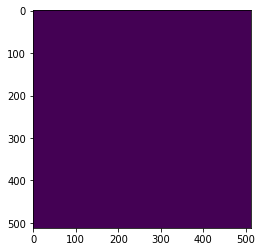

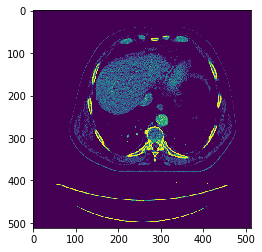

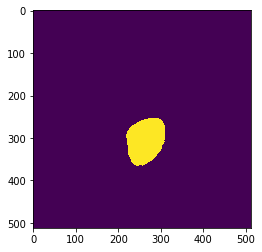

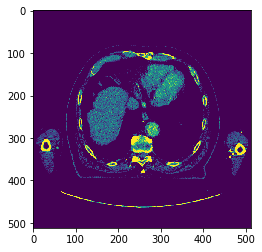

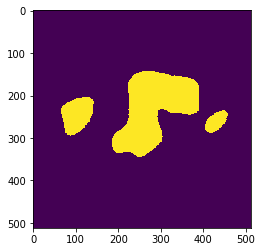

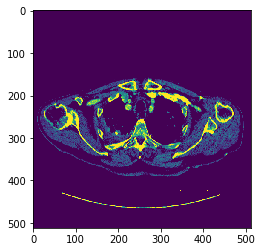

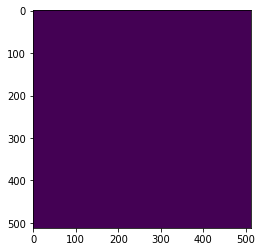

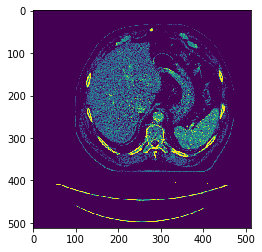

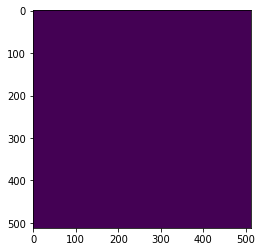

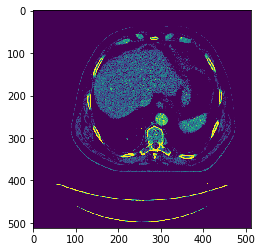

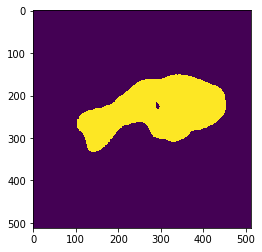

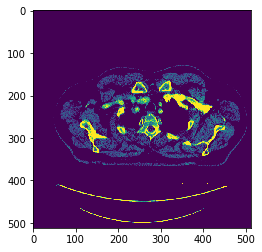

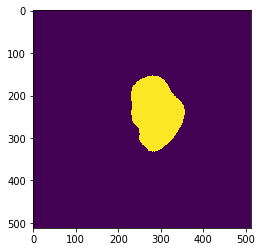

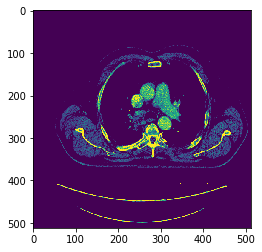

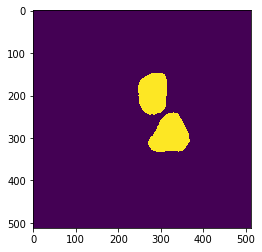

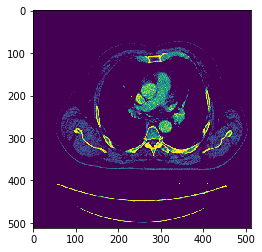

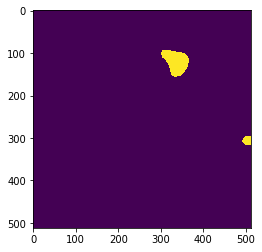

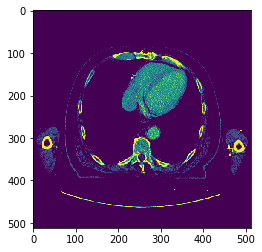

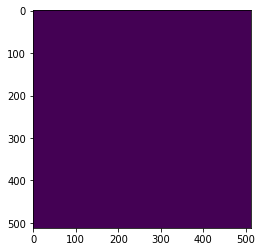

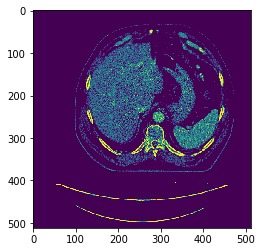

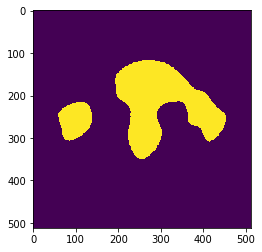

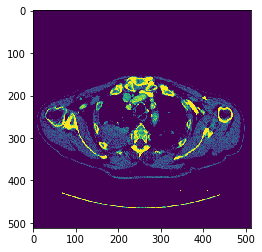

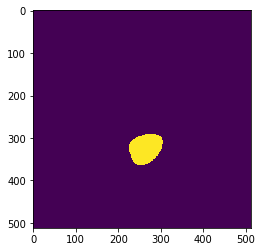

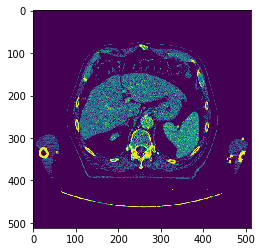

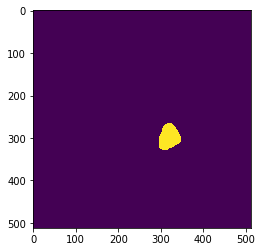

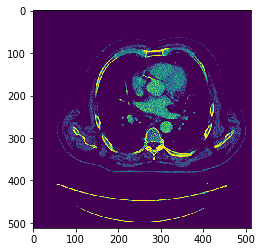

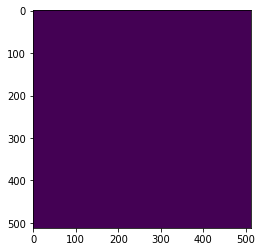

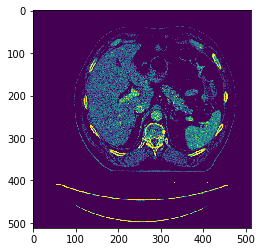

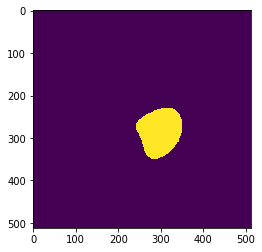

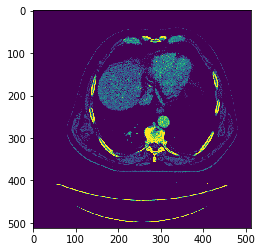

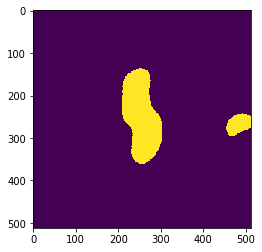

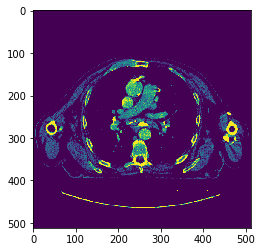

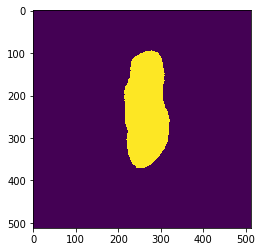

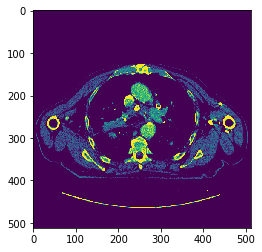

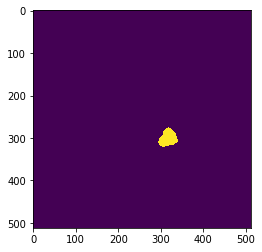

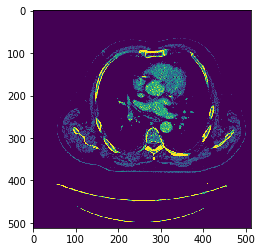

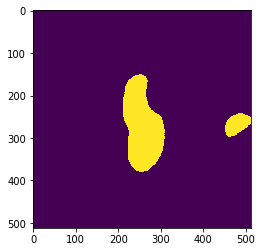

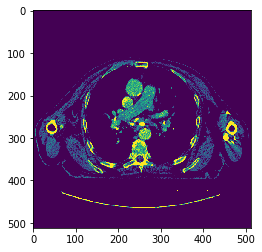

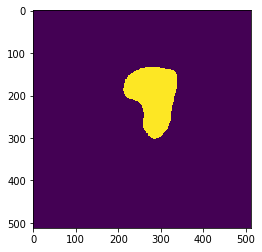

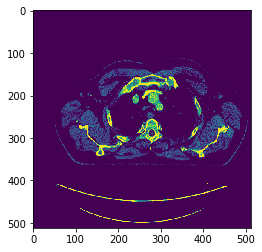

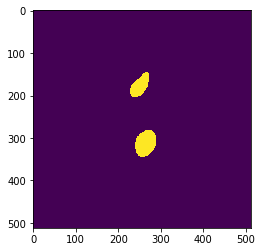

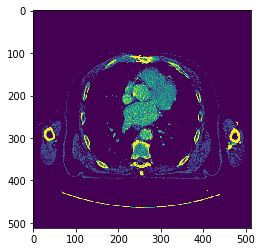

In [106]:


test_path = 'E:/path_test/'




pred = []
k = 0
x_test = np.zeros((30,512,512,1),dtype = np.uint8)
#x_test = np.zeros()
for i in os.listdir(test_path):
    
    imag = test_path+i
    img = cv2.imread(imag,0)
    #x_test[k]= img
    img = img.reshape(512,512,1)
    x_test[k]= img
    k = k+1
pred = model.predict(x_test)
    
    
preds_test_t = (pred > 0.5).astype(np.uint8)    
for i in range(30):
    
    plt.imshow(np.squeeze(preds_test_t[i]))
    plt.show()
    plt.imshow(np.squeeze(x_test[i]))
    plt.show()

# Viewing the Predictions

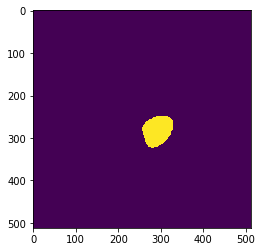

In [108]:
#pred = pred.reshape(512,512)
plt.imshow(np.squeeze(preds_test_t[5]))
plt.show()